<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchsummary import summary

torch.manual_seed(42)

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="../data/raw_data/KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="../data/raw_data/KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Кажется, что если размер батча слишком большой, то его обработка будет занимать слишком много времени и модель будет учиться долго. В то же время слишком маленькие батчи тоже могут замедлить обучение, так как не достигается оптимальная загрузка вычислительных мощностей.

Посмотрим на какую-нибудь картинку:

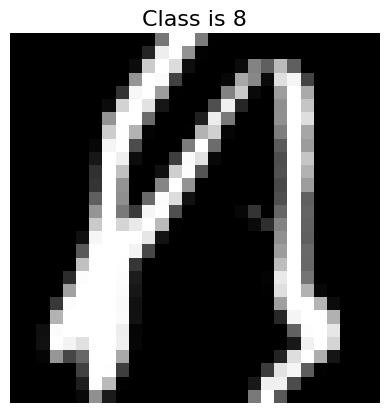

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





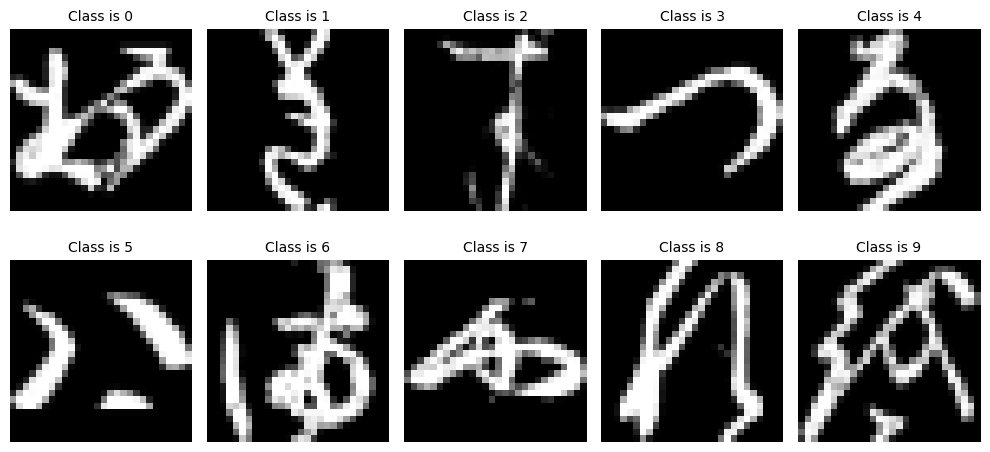

In [ ]:
categories = {}

for index, (_, label) in enumerate(trainset):
    if label not in categories:
        categories[label] = index

keys = list(categories.keys())
keys.sort()
sorted_categories = {i: categories[i] for i in keys}

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, key in enumerate(keys):
    row = i // 5
    col = i % 5
    index = categories[key]
    ax = axes[row, col]
    ax.imshow(trainset[index][0].view(28, 28).numpy(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Class is {trainset[index][1]}", fontsize=10)

plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
      super().__init__() #  это надо помнить!

      # Define 3 fully connected layers

      # in_features число входов у каждого нейрона, out_features число нейронов
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      # in_features число нейронов пред слоя, out_features число классов (10)
      self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
      ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
      ## надо подумать над тем, что у нас полносвязные слои принимают векторы
      x = x.view(-1, 28*28)

      x = self.fc1(x)
      x = nn.ReLU()(x)
      x = self.fc2(x)
      x = nn.ReLU()(x)
      logits = self.fc3(x)

      return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [ ]:
# Ручной подсчет
first_fc = (28*28 + 1)*256
second_fc = (256 + 1)*128
third_fc = (128 + 1)*10

total_params = first_fc + second_fc + third_fc

print("Total parameters:", total_params)

Total parameters: 235146


In [ ]:
# Подсчет с помощью функции саммари
model = FCNet()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.90
Estimated Total Size (MB): 0.90
----------------------------------------------------------------


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9263
Epoch=2 loss=0.4329
Epoch=3 loss=0.3401
Epoch=4 loss=0.2860
Epoch=5 loss=0.2442
Epoch=6 loss=0.2131
Epoch=7 loss=0.1875
Epoch=8 loss=0.1642
Epoch=9 loss=0.1452
Epoch=10 loss=0.1292


In [ ]:
get_accuracy(fc_net, testloader)

0.8733

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
mean = torch.mean(torch.stack([torch.mean(tensor) for tensor, _ in trainset]))
std = torch.std(torch.stack([torch.std(tensor) for tensor, _ in trainset]))
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.0505)


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.4639
Epoch=2 loss=0.1924
Epoch=3 loss=0.1265
Epoch=4 loss=0.0881
Epoch=5 loss=0.0626
Epoch=6 loss=0.0435
Epoch=7 loss=0.0298
Epoch=8 loss=0.0203
Epoch=9 loss=0.0136
Epoch=10 loss=0.0097
CPU times: user 28.4 s, sys: 2.4 s, total: 30.8 s
Wall time: 2min 6s


In [ ]:
relu_accuracy = get_accuracy(fc_net, testloader)
relu_accuracy

0.9021

In [ ]:
relu_time = "CPU times total: 30.8 s / Wall time: 2min 6s"

Как изменилась `accuracy` после нормализации?

Accuracy повысилась после нормализации, а значит проводить нормализацию действительно нужно.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
      super().__init__() #  это надо помнить!

      # Define 3 fully connected layers

      # in_features число входов у каждого нейрона, out_features число нейронов
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      # in_features число нейронов пред слоя, out_features число классов (10)
      self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
      ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
      ## надо подумать над тем, что у нас полносвязные слои принимают векторы
      x = x.view(-1, 28*28)

      x = self.fc1(x)
      x = nn.Sigmoid()(x)
      x = self.fc2(x)
      x = nn.Sigmoid()(x)
      logits = self.fc3(x)

      return logits


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.3750
Epoch=2 loss=0.6172
Epoch=3 loss=0.4391
Epoch=4 loss=0.3455
Epoch=5 loss=0.2794
Epoch=6 loss=0.2300
Epoch=7 loss=0.1897
Epoch=8 loss=0.1577
Epoch=9 loss=0.1314
Epoch=10 loss=0.1091
CPU times: user 28.3 s, sys: 2.42 s, total: 30.7 s
Wall time: 2min 11s


In [ ]:
sigmoid_accuracy = get_accuracy(fc_net, testloader)

In [ ]:
sigmoid_accuracy

0.8569

In [ ]:
sigmoid_time = "CPU times total: 30.7 s / Wall time: 2min 11s"

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
      super().__init__() #  это надо помнить!

      # Define 3 fully connected layers

      # in_features число входов у каждого нейрона, out_features число нейронов
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      # in_features число нейронов пред слоя, out_features число классов (10)
      self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
      ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
      ## надо подумать над тем, что у нас полносвязные слои принимают векторы
      x = x.view(-1, 28*28)

      x = self.fc1(x)
      x = nn.GELU()(x)
      x = self.fc2(x)
      x = nn.GELU()(x)
      logits = self.fc3(x)

      return logits


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.4476
Epoch=2 loss=0.1875
Epoch=3 loss=0.1247
Epoch=4 loss=0.0858
Epoch=5 loss=0.0606
Epoch=6 loss=0.0428
Epoch=7 loss=0.0289
Epoch=8 loss=0.0194
Epoch=9 loss=0.0133
Epoch=10 loss=0.0082
CPU times: user 29.6 s, sys: 2.37 s, total: 32 s
Wall time: 2min 6s


In [ ]:
gelu_accuracy = get_accuracy(fc_net, testloader)

In [ ]:
gelu_accuracy

0.9075

In [ ]:
gelu_time = "CPU times total: 32 s / Wall time: 2min 6s"

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
      super().__init__() #  это надо помнить!

      # Define 3 fully connected layers

      # in_features число входов у каждого нейрона, out_features число нейронов
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      # in_features число нейронов пред слоя, out_features число классов (10)
      self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
      ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
      ## надо подумать над тем, что у нас полносвязные слои принимают векторы
      x = x.view(-1, 28*28)

      x = self.fc1(x)
      x = nn.Tanh()(x)
      x = self.fc2(x)
      x = nn.Tanh()(x)
      logits = self.fc3(x)

      return logits


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad()
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.7039
Epoch=2 loss=0.3181
Epoch=3 loss=0.2118
Epoch=4 loss=0.1503
Epoch=5 loss=0.1089
Epoch=6 loss=0.0775
Epoch=7 loss=0.0546
Epoch=8 loss=0.0374
Epoch=9 loss=0.0248
Epoch=10 loss=0.0156
CPU times: user 28.4 s, sys: 2.39 s, total: 30.8 s
Wall time: 2min 4s


In [ ]:
tanh_accuracy = get_accuracy(fc_net, testloader)

In [ ]:
tanh_accuracy

0.877

In [ ]:
tanh_time = "CPU times total: 30.8 s / Wall time: 2min 4s"

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Наибольшая accuracy при использовании Gelu, хотя она очень близка с Relu. По скорости обучения особой разницы не было.

In [ ]:
print(f"Accuracy with Relu is {relu_accuracy}; time is {relu_time}")
print(f"Accuracy with Gelu is {gelu_accuracy}; time is {gelu_time}")
print(f"Accuracy with Sigmoid is {sigmoid_accuracy}; time is {sigmoid_time}")
print(f"Accuracy with Tanh is {tanh_accuracy}; time is {tanh_time}")

Accuracy with Relu is 0.9021; time is CPU times total: 30.9 s / Wall time: 2min 7s
Accuracy with Gelu is 0.9075; time is CPU times total: 32 s / Wall time: 2min 6s
Accuracy with Sigmoid is 0.8569; time is CPU times total: 31.1 s / Wall time: 2min 8s
Accuracy with Tanh is 0.877; time is CPU times total: 30.8 s / Wall time: 2min 4s


### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
      super().__init__() #  это надо помнить!

      # Define 3 fully connected layers

      # in_features число входов у каждого нейрона, out_features число нейронов
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      # in_features число нейронов пред слоя, out_features число классов (10)
      self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
      ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
      ## надо подумать над тем, что у нас полносвязные слои принимают векторы
      x = x.view(-1, 28*28)

      x = self.fc1(x)
      x = nn.GELU()(x)
      x = self.fc2(x)
      x = nn.GELU()(x)
      logits = self.fc3(x)

      return logits


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer_adam = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
optimizer_RMSprop = torch.optim.RMSprop(fc_net.parameters(), lr=3e-4)
optimizer_Adagrad = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_adam.zero_grad()
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_adam.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.4541
Epoch=2 loss=0.1862
Epoch=3 loss=0.1210
Epoch=4 loss=0.0850
Epoch=5 loss=0.0604
Epoch=6 loss=0.0412
Epoch=7 loss=0.0280
Epoch=8 loss=0.0193
Epoch=9 loss=0.0132
Epoch=10 loss=0.0084
CPU times: user 29.5 s, sys: 2.41 s, total: 31.9 s
Wall time: 2min 5s


In [ ]:
adam_accuracy = get_accuracy(fc_net, testloader)

In [ ]:
adam_accuracy

0.9037

In [ ]:
adam_time = "CPU times total: 31.9 s / Wall time: 2min 5s"

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_RMSprop.zero_grad()
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_RMSprop.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.0498
Epoch=2 loss=0.0181
Epoch=3 loss=0.0151
Epoch=4 loss=0.0186
Epoch=5 loss=0.0118
Epoch=6 loss=0.0114
Epoch=7 loss=0.0084
Epoch=8 loss=0.0079
Epoch=9 loss=0.0103
Epoch=10 loss=0.0101
CPU times: user 27.9 s, sys: 2.32 s, total: 30.2 s
Wall time: 2min 4s


In [ ]:
rmsprop_accuracy = get_accuracy(fc_net, testloader)

In [ ]:
rmsprop_accuracy

0.8982

In [ ]:
rmsprop_time = "CPU times total: 30.2 s / Wall time: 2min 4s"

In [ ]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_Adagrad.zero_grad()
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_Adagrad.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.0021
Epoch=2 loss=0.0008
Epoch=3 loss=0.0006
Epoch=4 loss=0.0005
Epoch=5 loss=0.0005
Epoch=6 loss=0.0005
Epoch=7 loss=0.0004
Epoch=8 loss=0.0004
Epoch=9 loss=0.0004
Epoch=10 loss=0.0004
CPU times: user 27.9 s, sys: 2.36 s, total: 30.2 s
Wall time: 2min 7s


In [ ]:
adagrad_accuracy = get_accuracy(fc_net, testloader)

In [ ]:
adagrad_accuracy

0.9084

In [ ]:
adagrad_time = "CPU times total: 30.2 s / Wall time: 2min 7s"

In [ ]:
print(f"Accuracy with Adam optimiser is {adam_accuracy}; time is {adam_time}")
print(f"Accuracy with RMSprop optimiser is {rmsprop_accuracy}; time is {rmsprop_time}")
print(f"Accuracy with Adagrad optimiser is {adagrad_accuracy}; time is {adagrad_time}")

Accuracy with Adam optimiser is 0.9037; time is CPU times total: 31.9 s / Wall time: 2min 5s
Accuracy with RMSprop optimiser is 0.8982; time is CPU times total: 30.2 s / Wall time: 2min 4s
Accuracy with Adagrad optimiser is 0.9084; time is CPU times total: 30.2 s / Wall time: 2min 7s


Accuracy немного лучше с Adagrad, но вряд ли значимо. Можно заключить что большой разницы во времени обучения и accuracy при использовании трех оптимайзеров не наблюдалось.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # если элемент x < 0, то 0, если >= 0, то x
        x = torch.where(x < 0.0, torch.zeros_like(x), x)

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
      super().__init__() #  это надо помнить!

      # Define 3 fully connected layers

      # in_features число входов у каждого нейрона, out_features число нейронов
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      # in_features число нейронов пред слоя, out_features число классов (10)
      self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
      ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
      ## надо подумать над тем, что у нас полносвязные слои принимают векторы
      x = x.view(-1, 28*28)

      x = self.fc1(x)
      relu = CustomReLU()
      x = relu(x)
      x = self.fc2(x)
      x = relu(x)
      logits = self.fc3(x)

      return logits


In [ ]:
fc_net_custom_relu = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer_adam = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_Adagrad.zero_grad()
        outputs = fc_net_custom_relu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_Adagrad.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

In [ ]:
custom_relu_accuracy = get_accuracy(fc_net_custom_relu, testloader)

In [ ]:
print(f"Defaul Relu accuracy {relu_accuracy}")
print(f"Custom Relu accuracy {custom_relu_accuracy}")

Defaul Relu accuracy 0.9021
Custom Relu accuracy 0.0912


Что-то пошло не так...

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Я использовала @kandinsky21_bot

1. Искусственный интеллект, который пытается познать сам себя
2. Голубой цветок магнолии
3. Биоинформатические алгоритмы




In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
uploaded = files.upload()

Saving 1.jpg to 1.jpg


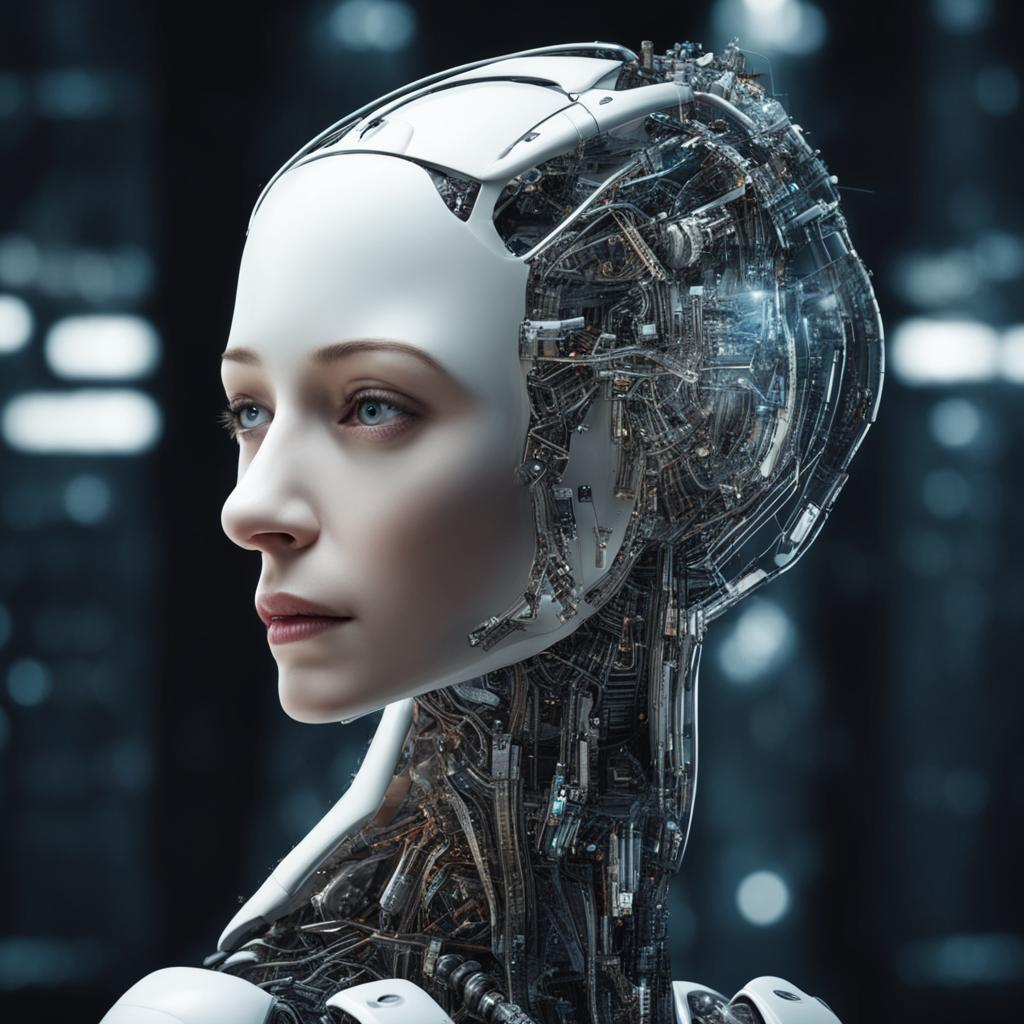

In [ ]:
Image("1.jpg", width = 200)

In [ ]:
uploaded2 = files.upload()

Saving 2.jpg to 2.jpg


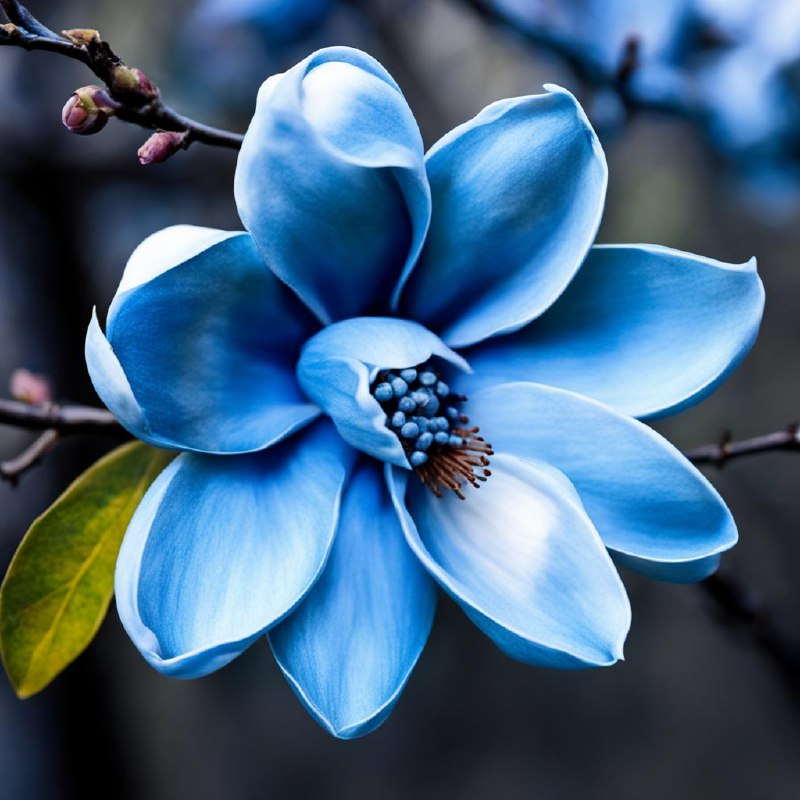

In [ ]:
Image("2.jpg", width = 200)

In [ ]:
uploaded3 = files.upload()

Saving 3.jpg to 3.jpg


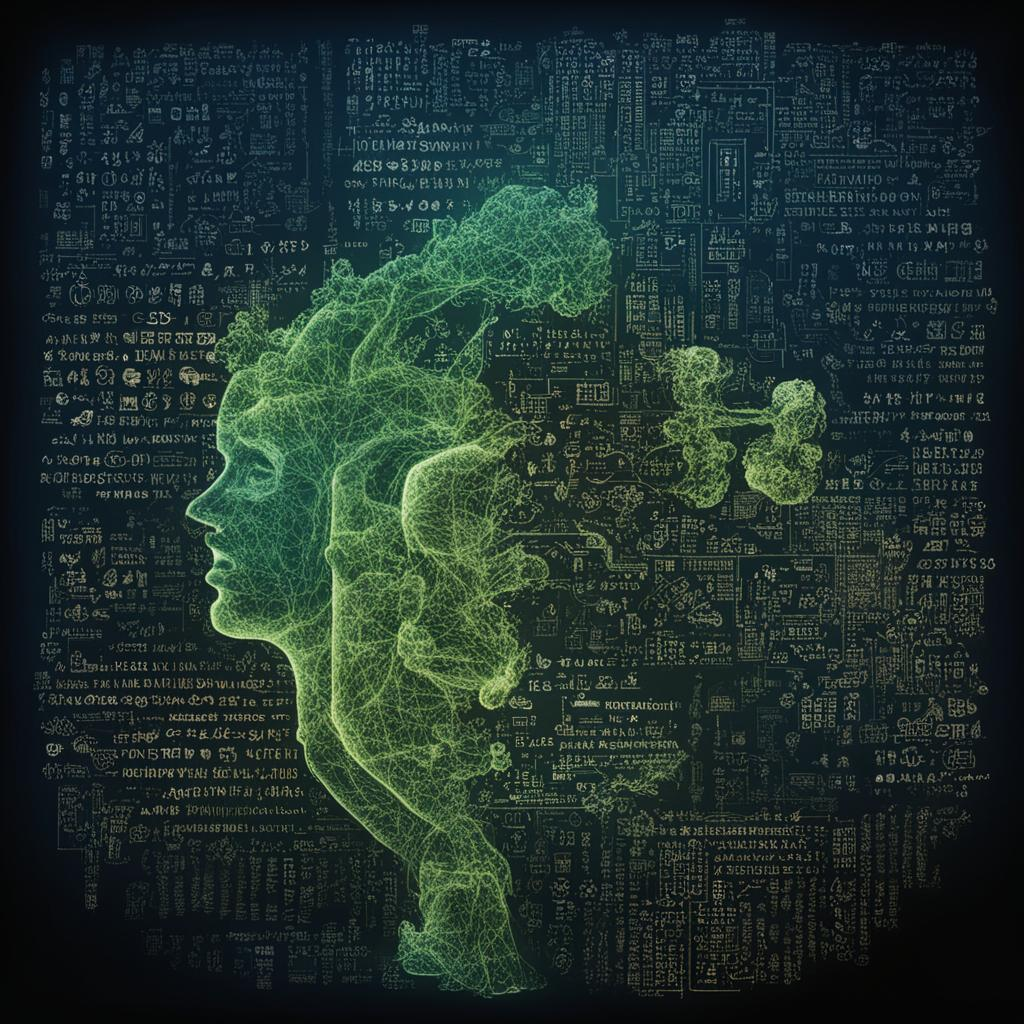

In [ ]:
Image("3.jpg", width = 200)

In [ ]:
Image(filename = "../data_folder/1.jpg", width=200, height=200)

In [ ]:
Image(filename = "../data_folder/2.jpg", width=200, height=200)

In [ ]:
Image(filename = "../data_folder/3.jpg", width=200, height=200)